In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

from skimage.restoration import wiener
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import torch
from lpips import LPIPS

In [87]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
lpips_model = LPIPS(net="alex").to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


In [9]:
BSD500_PATH = "datasets/BSD500"
DIV2K_PATH = "datasets/DIV2K_valid_HR"
CUSTOM_PATH = "datasets/Own"

In [10]:
bsd_images = glob(os.path.join(BSD500_PATH, "*.*"))
div2k_images = glob(os.path.join(DIV2K_PATH, "*.*"))

custom_images = glob(os.path.join(CUSTOM_PATH, "*.*"))

print("BSD500 images:", len(bsd_images))
print("DIV2K images:", len(div2k_images))
print("Custom dataset images:", len(custom_images))
print("Total images loaded:", len(bsd_images) + len(div2k_images) + len(custom_images))

BSD500 images: 200
DIV2K images: 100
Custom dataset images: 100
Total images loaded: 400


In [ ]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0  
    return img

In [14]:
def add_gaussian_noise(img, sigma):
    noise = np.random.normal(0, sigma/255.0, img.shape).astype(np.float32)
    noisy = img + noise
    return np.clip(noisy, 0, 1)

In [19]:
def apply_wiener(img, balance=0.1):

    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = gray.astype(np.float32) / 255.0

    psf = np.ones((3, 3), np.float32) / 9.0
    restored = wiener(gray, psf, balance)

    restored = np.clip(restored, 0, 1)
    restored_rgb = np.stack([restored]*3, axis=-1)  
    return restored_rgb

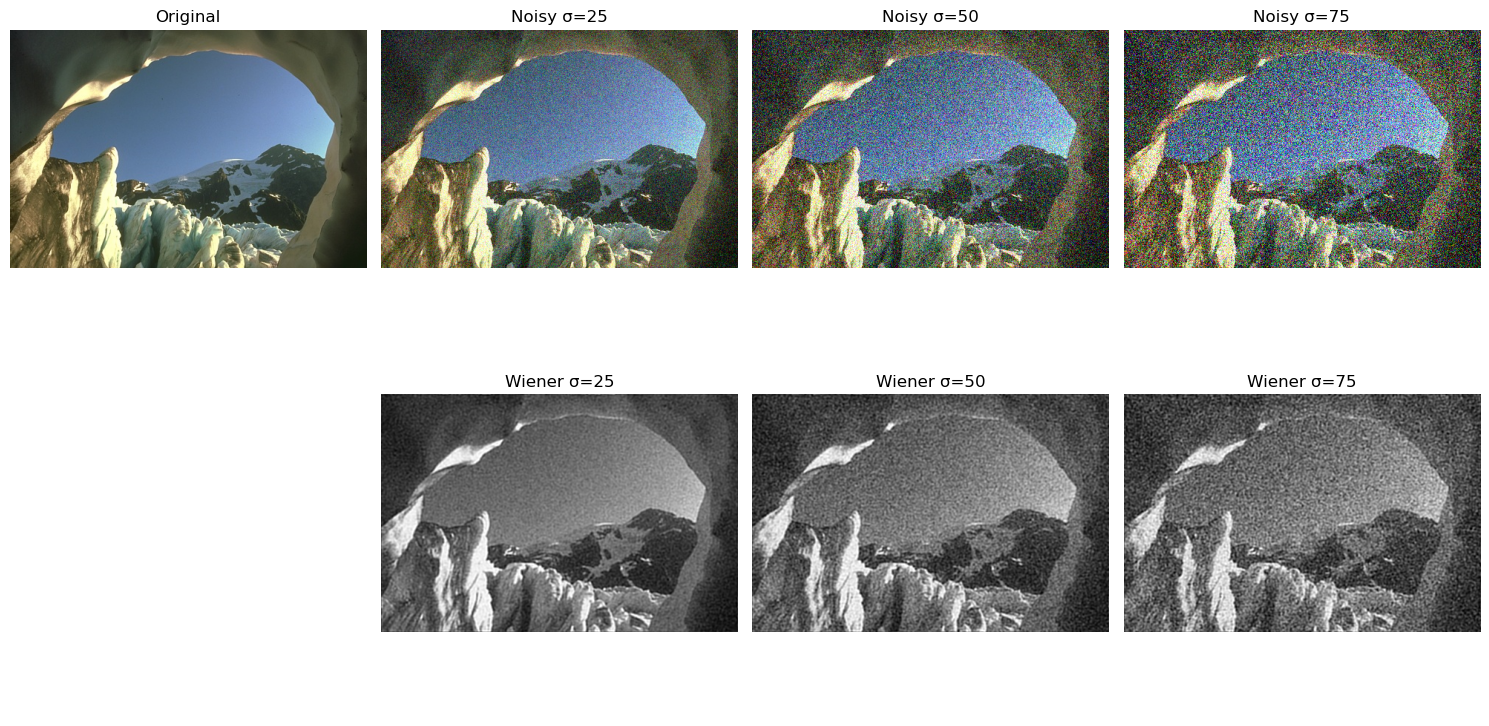

In [ ]:
sample_path = bsd_images[105]   # change index if you want a nicer image
sample = load_image(sample_path)

plt.figure(figsize=(15,8))

# Generate noisy versions
noisy25 = add_gaussian_noise(sample, 25)
noisy50 = add_gaussian_noise(sample, 50)
noisy75 = add_gaussian_noise(sample, 75)

# Apply Wiener filter
w25 = apply_wiener(noisy25)
w50 = apply_wiener(noisy50)
w75 = apply_wiener(noisy75)

plt.subplot(2,4,1); plt.imshow(sample); plt.title("Original"); plt.axis("off")
plt.subplot(2,4,2); plt.imshow(noisy25); plt.title("Noisy σ=25"); plt.axis("off")
plt.subplot(2,4,3); plt.imshow(noisy50); plt.title("Noisy σ=50"); plt.axis("off")
plt.subplot(2,4,4); plt.imshow(noisy75); plt.title("Noisy σ=75"); plt.axis("off")

plt.subplot(2,4,1+4); plt.axis("off")  

plt.subplot(2,4,2+4); plt.imshow(w25); plt.title("Wiener σ=25"); plt.axis("off")
plt.subplot(2,4,3+4); plt.imshow(w50); plt.title("Wiener σ=50"); plt.axis("off")
plt.subplot(2,4,4+4); plt.imshow(w75); plt.title("Wiener σ=75"); plt.axis("off")

plt.tight_layout()
plt.show()


In [20]:
def compute_metrics(clean, denoised):
    psnr = peak_signal_noise_ratio(clean, denoised, data_range=1.0)
    ssim = structural_similarity(clean, denoised, data_range=1.0, channel_axis=2)
    return psnr, ssim

In [21]:
def compute_lpips(img1, img2):
    t1 = torch.tensor(img1).permute(2,0,1).unsqueeze(0).float()
    t2 = torch.tensor(img2).permute(2,0,1).unsqueeze(0).float()

    t1 = (t1 * 2 - 1).to(device)
    t2 = (t2 * 2 - 1).to(device)

    with torch.no_grad():
        dist = lpips_model(t1, t2)

    return dist.item()

In [108]:
def evaluate_public_dataset(image_paths, name="Public Dataset"):
    sigmas = [25, 50, 75]
    results = {s: [] for s in sigmas}

    print(f"\n Evaluating {name}")

    for path in tqdm(image_paths):
        clean = load_image(path)

        for sigma in sigmas:
            noisy = add_gaussian_noise(clean, sigma)
            denoised = apply_wiener(noisy)

            psnr, ssim = compute_metrics(clean, denoised)
            results[sigma].append((psnr, ssim))

    for sigma in sigmas:
        psnrs = [p for p, s in results[sigma]]
        ssims = [s for p, s in results[sigma]]

        print(f"σ={sigma}: Avg PSNR = {np.mean(psnrs):.4f}, Avg SSIM = {np.mean(ssims):.4f}")

    return results


In [109]:
results_bsd = evaluate_public_dataset(bsd_images, "BSD500")
results_div2k = evaluate_public_dataset(div2k_images, "DIV2K")


 Evaluating BSD500


100%|██████████| 200/200 [00:11<00:00, 17.44it/s]


σ=25: Avg PSNR = 20.1531, Avg SSIM = 0.6595
σ=50: Avg PSNR = 18.9001, Avg SSIM = 0.4763
σ=75: Avg PSNR = 17.5446, Avg SSIM = 0.3637

 Evaluating DIV2K


100%|██████████| 100/100 [02:18<00:00,  1.38s/it]

σ=25: Avg PSNR = 20.6559, Avg SSIM = 0.6334
σ=50: Avg PSNR = 19.1419, Avg SSIM = 0.4398
σ=75: Avg PSNR = 17.5964, Avg SSIM = 0.3286


In [110]:
def evaluate_custom_dataset(image_paths):
    lpips_scores = []

    print("\n Evaluating Custom Dataset (LPIPS)")

    for path in tqdm(image_paths):
        noisy_real = load_image(path)
        denoised = apply_wiener(noisy_real)

        lp = compute_lpips(noisy_real, denoised)
        lpips_scores.append(lp)

    avg_lp = np.mean(lpips_scores)
    print(f"Avg LPIPS (Wiener): {avg_lp:.4f}")

    return lpips_scores

In [111]:
custom_lpips = evaluate_custom_dataset(custom_images)


 Evaluating Custom Dataset (LPIPS)


100%|██████████| 100/100 [07:58<00:00,  4.79s/it]


Avg LPIPS (Wiener): 0.2418


In [114]:
print("\n=== BSD500 Results ===")
for sigma, metrics in results_bsd.items():
    psnrs = [p for (p, s) in metrics]
    ssims = [s for (p, s) in metrics]
    print(f"σ={sigma}: PSNR={np.mean(psnrs):.3f}, SSIM={np.mean(ssims):.3f}")

print("\n=== DIV2K Results ===")
for sigma, metrics in results_div2k.items():
    psnrs = [p for (p, s) in metrics]
    ssims = [s for (p, s) in metrics]
    print(f"σ={sigma}: PSNR={np.mean(psnrs):.3f}, SSIM={np.mean(ssims):.3f}")

print("\n=== Custom Dataset ===")
print(f"Avg LPIPS = {np.mean(custom_lpips):.4f}")


=== BSD500 Results ===
σ=25: PSNR=20.153, SSIM=0.659
σ=50: PSNR=18.900, SSIM=0.476
σ=75: PSNR=17.545, SSIM=0.364

=== DIV2K Results ===
σ=25: PSNR=20.656, SSIM=0.633
σ=50: PSNR=19.142, SSIM=0.440
σ=75: PSNR=17.596, SSIM=0.329

=== Custom Dataset ===
Avg LPIPS = 0.2418


In [22]:
def add_noise_and_save(clean_path, sigma, out_folder):
    """
    Loads a clean image, adds Gaussian noise with std=sigma,
    and saves the noisy image into out_folder.
    """
    img = cv2.imread(clean_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

    noise = np.random.normal(0, sigma, img.shape)
    noisy = img + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)

    filename = os.path.basename(clean_path)
    save_path = os.path.join(out_folder, filename)

    cv2.imwrite(save_path, cv2.cvtColor(noisy, cv2.COLOR_RGB2BGR))

In [23]:
def create_noisy_versions(clean_folder, out_prefix):
    """
    clean_folder: path to clean dataset (e.g., BSD500 or DIV2K)
    out_prefix: name for output folders (e.g., 'bsd500' or 'div2k')
    """
    clean_images = glob(os.path.join(clean_folder, "*.*"))
    print(f"Found {len(clean_images)} clean images in {clean_folder}")

    # Output folders
    target_25 = f"Model/DiffPIR/testsets/{out_prefix}_25"
    target_50 = f"Model/DiffPIR/testsets/{out_prefix}_50"
    target_75 = f"Model/DiffPIR/testsets/{out_prefix}_75"

    os.makedirs(target_25, exist_ok=True)
    os.makedirs(target_50, exist_ok=True)
    os.makedirs(target_75, exist_ok=True)

    for img_path in tqdm(clean_images):
        add_noise_and_save(img_path, sigma=25, out_folder=target_25)
        add_noise_and_save(img_path, sigma=50, out_folder=target_50)
        add_noise_and_save(img_path, sigma=75, out_folder=target_75)

In [164]:
create_noisy_versions("Datasets/BSD500", "bsd500")
create_noisy_versions("Datasets/DIV2K_valid_HR", "div2k")

Found 200 clean images in Datasets/BSD500


100%|██████████| 200/200 [00:04<00:00, 41.72it/s]


Found 100 clean images in Datasets/DIV2K_valid_HR


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


In [24]:
from bm3d import bm3d, BM3DProfile
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from bm3d import bm3d, BM3DProfile

def bm3d_denoise(noisy_img, sigma):
    """
    noisy_img: float32 image in [0,1]
    sigma: noise std in [0,1]
    """
    profile = BM3DProfile()  # default profile
    denoised = bm3d(noisy_img, sigma, profile=profile)
    return np.clip(denoised, 0, 1)

In [ ]:
def evaluate_bm3d_dataset(image_paths, name="Dataset BM3D"):
    sigmas = [25, 50, 75]
    results = {s: [] for s in sigmas}

    print(f"\n---- Evaluating {name} with BM3D ----")

    for path in tqdm(image_paths):
        clean = load_image(path)   
        
        for sigma in sigmas:
            noise_level = sigma / 255.0
            noisy = add_gaussian_noise(clean, sigma)

            denoised = bm3d_denoise(noisy, noise_level)

            psnr = peak_signal_noise_ratio(clean, denoised, data_range=1.0)
            ssim = structural_similarity(clean, denoised, data_range=1.0,
                                         channel_axis=2)

            results[sigma].append((psnr, ssim))

    for sigma in sigmas:
        psnrs = [p for p, _ in results[sigma]]
        ssims = [s for _, s in results[sigma]]
        print(f"σ={sigma}: PSNR={np.mean(psnrs):.4f}, SSIM={np.mean(ssims):.4f}")

    return results

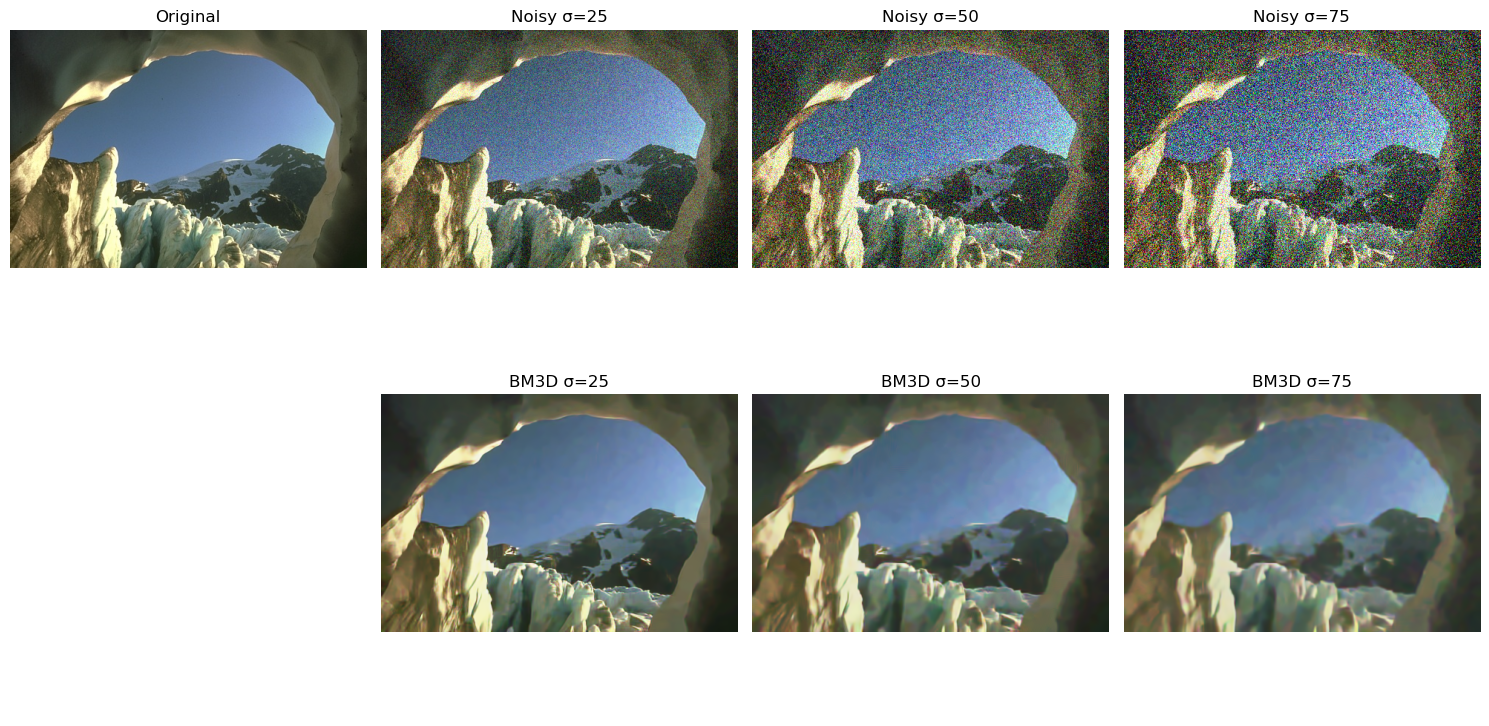

In [ ]:
import matplotlib.pyplot as plt

# Choose a sample image from BSD500
sample_path = bsd_images[105]   # change index if needed
sample = load_image(sample_path)

plt.figure(figsize=(15,8))

# Generate noisy images
noisy25 = add_gaussian_noise(sample, 25)
noisy50 = add_gaussian_noise(sample, 50)
noisy75 = add_gaussian_noise(sample, 75)

# Apply BM3D denoising
bm25 = bm3d_denoise(noisy25, 25/255)
bm50 = bm3d_denoise(noisy50, 50/255)
bm75 = bm3d_denoise(noisy75, 75/255)

plt.subplot(2,4,1); plt.imshow(sample); plt.title("Original"); plt.axis("off")
plt.subplot(2,4,2); plt.imshow(noisy25); plt.title("Noisy σ=25"); plt.axis("off")
plt.subplot(2,4,3); plt.imshow(noisy50); plt.title("Noisy σ=50"); plt.axis("off")
plt.subplot(2,4,4); plt.imshow(noisy75); plt.title("Noisy σ=75"); plt.axis("off")

plt.subplot(2,4,5); plt.axis("off")  # blank box for symmetry
plt.subplot(2,4,6); plt.imshow(bm25); plt.title("BM3D σ=25"); plt.axis("off")
plt.subplot(2,4,7); plt.imshow(bm50); plt.title("BM3D σ=50"); plt.axis("off")
plt.subplot(2,4,8); plt.imshow(bm75); plt.title("BM3D σ=75"); plt.axis("off")

plt.tight_layout()
plt.show()

In [256]:
results_bsd_bm3d = evaluate_bm3d_dataset(bsd_images, "BSD500 (BM3D)")
results_div_bm3d = evaluate_bm3d_dataset(div2k_images, "DIV2K (BM3D)")


---- Evaluating BSD500 (BM3D) with BM3D ----


100%|██████████| 200/200 [56:15<00:00, 16.88s/it]


σ=25: PSNR=28.5428, SSIM=0.8026
σ=50: PSNR=24.7838, SSIM=0.6618
σ=75: PSNR=22.2506, SSIM=0.5734

---- Evaluating DIV2K (BM3D) with BM3D ----


100%|██████████| 100/100 [5:26:13<00:00, 195.74s/it] 

σ=25: PSNR=30.2261, SSIM=0.8281
σ=50: PSNR=25.7846, SSIM=0.7143
σ=75: PSNR=22.6373, SSIM=0.6319


In [ ]:
device_lpips = "cpu"
lpips_model = LPIPS(net="alex").to(device_lpips)

def lpips_tensor(img_uint8):
    img = img_uint8.astype(np.float32) / 255.0
    img = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0)
    return img * 2 - 1  

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/opt/anaconda3/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu')

In [263]:
def evaluate_bm3d_lpips(image_paths, name="Own Dataset (BM3D)"):
    print(f"\n---- Evaluating {name} with BM3D + LPIPS ----")
    lpips_scores = []

    for path in tqdm(image_paths):
        clean = load_image(path).astype(np.float32) / 255.0

        sigma = 25
        noisy = add_gaussian_noise(clean, sigma)

        noise_level = sigma / 255.0
        denoised = bm3d(noisy, noise_level)
        denoised = np.clip(denoised, 0, 1)

        noisy_uint8 = (noisy * 255).astype(np.uint8)
        denoised_uint8 = (denoised * 255).astype(np.uint8)

        noisy_t = lpips_tensor(noisy_uint8).to("cpu")
        denoised_t = lpips_tensor(denoised_uint8).to("cpu")

        score = lpips_model(noisy_t, denoised_t).item()
        lpips_scores.append(score)

    print(f"Average LPIPS: {np.mean(lpips_scores):.4f}")
    return lpips_scores

In [264]:
bm3d_lpips_scores = evaluate_bm3d_lpips(custom_images, "Own Dataset (BM3D)")


---- Evaluating Own Dataset (BM3D) with BM3D + LPIPS ----


100%|██████████| 100/100 [9:11:57<00:00, 331.17s/it] 

Average LPIPS: 0.8857


In [266]:
print("\n=== BSD500 Results (BM3D) ===")
for sigma, metrics in results_bsd_bm3d.items():
    psnrs = [p for (p, s) in metrics]
    ssims = [s for (p, s) in metrics]
    print(f"σ={sigma}: PSNR={np.mean(psnrs):.3f}, SSIM={np.mean(ssims):.3f}")

print("\n=== DIV2K Results (BM3D) ===")
for sigma, metrics in results_div_bm3d.items():
    psnrs = [p for (p, s) in metrics]
    ssims = [s for (p, s) in metrics]
    print(f"σ={sigma}: PSNR={np.mean(psnrs):.3f}, SSIM={np.mean(ssims):.3f}")

print("\n=== Own Dataset (BM3D) ===")
print(f"Avg LPIPS = {np.mean(bm3d_lpips_scores):.4f}")


=== BSD500 Results (BM3D) ===
σ=25: PSNR=28.543, SSIM=0.803
σ=50: PSNR=24.784, SSIM=0.662
σ=75: PSNR=22.251, SSIM=0.573

=== DIV2K Results (BM3D) ===
σ=25: PSNR=30.226, SSIM=0.828
σ=50: PSNR=25.785, SSIM=0.714
σ=75: PSNR=22.637, SSIM=0.632

=== Own Dataset (BM3D) ===
Avg LPIPS = 0.8857


In [ ]:
import matplotlib.pyplot as plt

def show_comparison(sample_path):
    sample = load_image(sample_path)

    noisy25 = add_gaussian_noise(sample, 25)
    noisy50 = add_gaussian_noise(sample, 50)
    noisy75 = add_gaussian_noise(sample, 75)

    # Wiener denoising
    w25 = apply_wiener(noisy25)
    w50 = apply_wiener(noisy50)
    w75 = apply_wiener(noisy75)

    # BM3D denoising
    b25 = bm3d_denoise(noisy25, 25/255.0)
    b50 = bm3d_denoise(noisy50, 50/255.0)
    b75 = bm3d_denoise(noisy75, 75/255.0)

    plt.figure(figsize=(16, 10))

    plt.subplot(3,4,1); plt.imshow(sample); plt.title("Original"); plt.axis("off")
    plt.subplot(3,4,2); plt.imshow(noisy25); plt.title("Noisy σ=25"); plt.axis("off")
    plt.subplot(3,4,3); plt.imshow(noisy50); plt.title("Noisy σ=50"); plt.axis("off")
    plt.subplot(3,4,4); plt.imshow(noisy75); plt.title("Noisy σ=75"); plt.axis("off")

    plt.subplot(3,4,5); plt.axis("off")  
    plt.subplot(3,4,6); plt.imshow(w25); plt.title("Wiener σ=25"); plt.axis("off")
    plt.subplot(3,4,7); plt.imshow(w50); plt.title("Wiener σ=50"); plt.axis("off")
    plt.subplot(3,4,8); plt.imshow(w75); plt.title("Wiener σ=75"); plt.axis("off")

    plt.subplot(3,4,9); plt.axis("off")
    plt.subplot(3,4,10); plt.imshow(b25); plt.title("BM3D σ=25"); plt.axis("off")
    plt.subplot(3,4,11); plt.imshow(b50); plt.title("BM3D σ=50"); plt.axis("off")
    plt.subplot(3,4,12); plt.imshow(b75); plt.title("BM3D σ=75"); plt.axis("off")

    plt.tight_layout()
    plt.show()

In [57]:
def safe_bm3d(noisy_uint8):
    # Convert to float [0,1]
    x = noisy_uint8.astype(np.float32) / 255.0
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)

    sigma = 0.10

    den = bm3d(x, sigma)

    den_uint8 = (den * 255).clip(0,255).astype(np.uint8)
    return den_uint8

In [58]:
def show_custom_dataset(sample_path):
    noisy_uint8 = load_image(sample_path)
    noisy_uint8 = cv2.resize(noisy_uint8, (512, 512))

    w_uint8 = apply_wiener(noisy_uint8)
    b_uint8 = safe_bm3d(noisy_uint8)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.subplot(1,3,1); plt.imshow(noisy_uint8); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(w_uint8);      plt.title("Wiener"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(b_uint8);      plt.title("BM3D"); plt.axis("off")
    plt.tight_layout()
    plt.show()

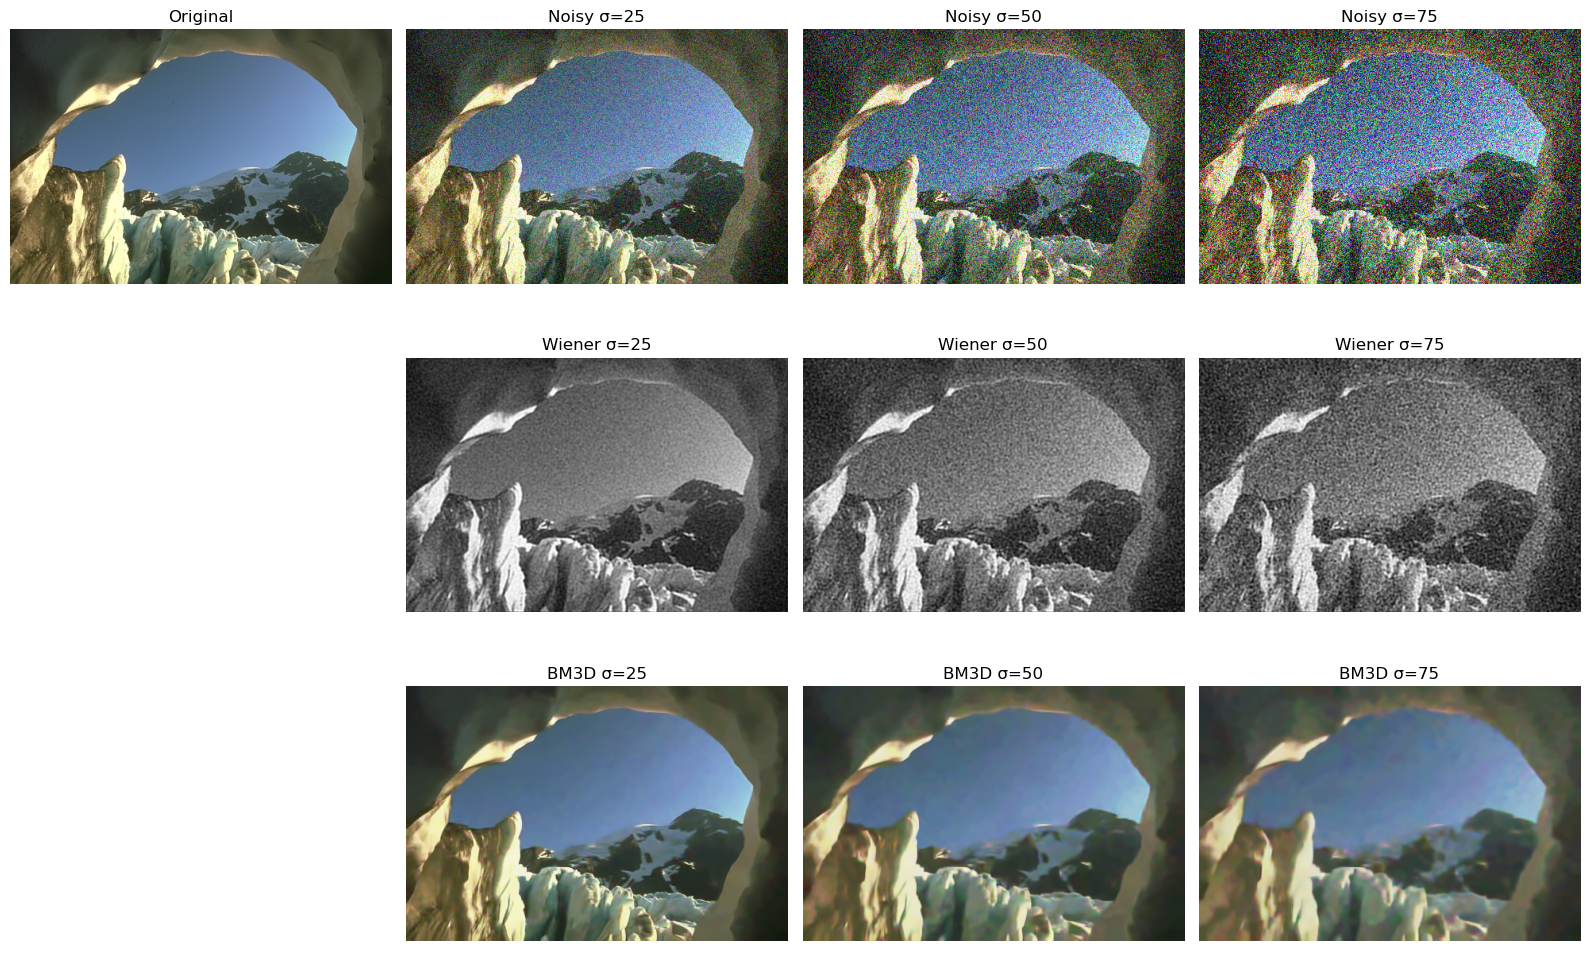

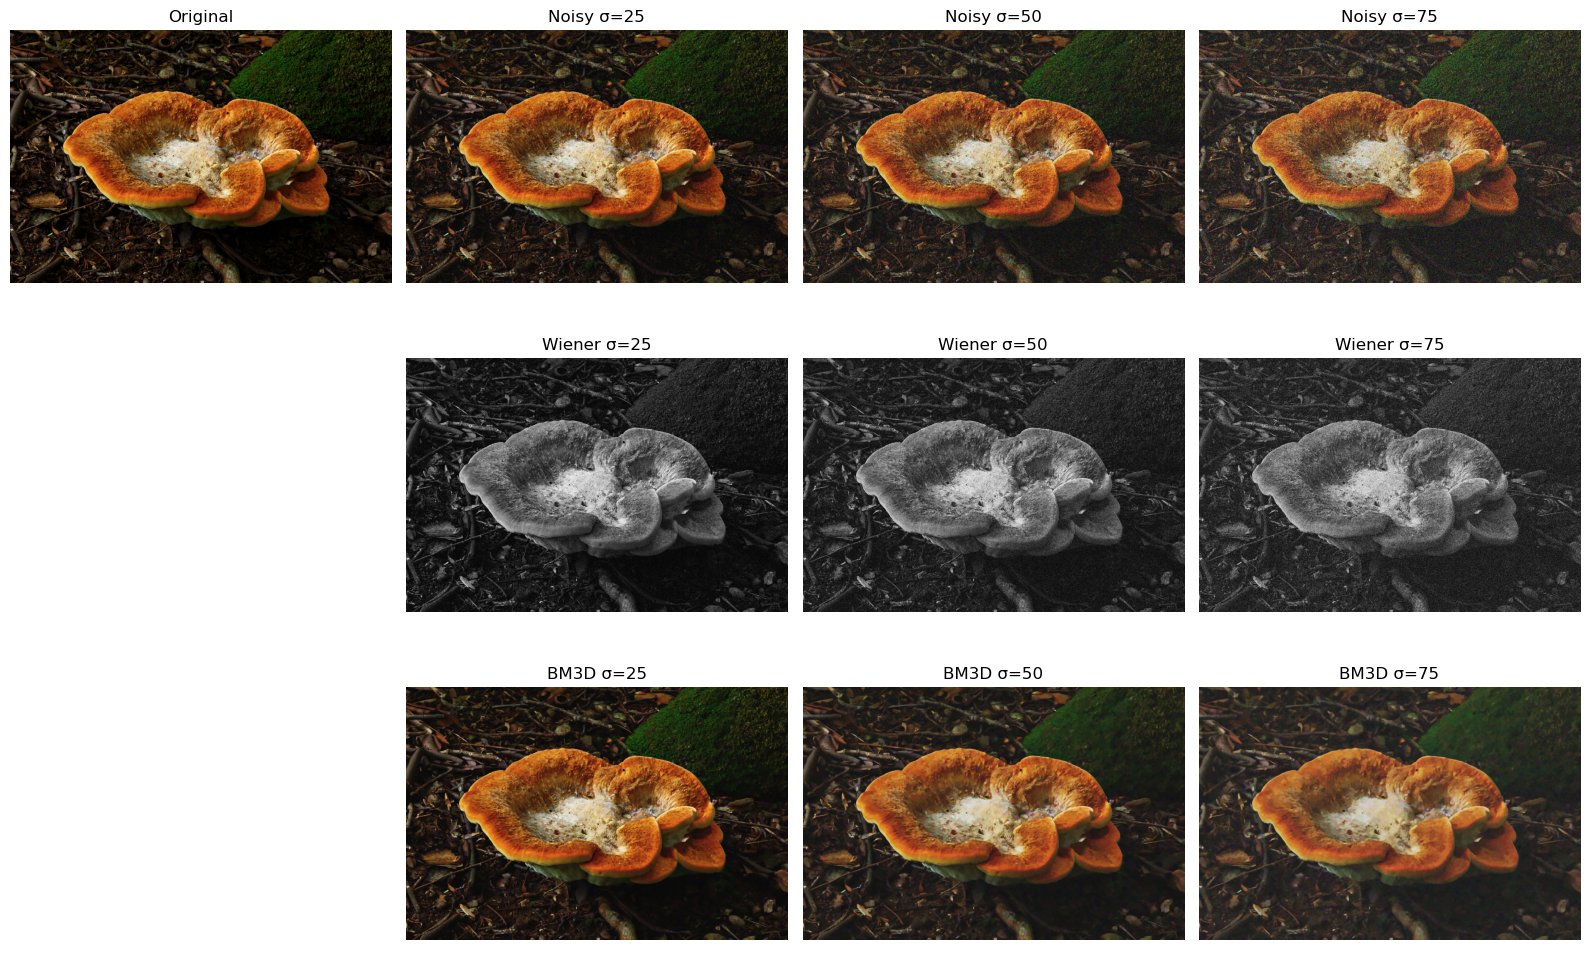

In [277]:
show_comparison(bsd_images[105])    
show_comparison(div2k_images[80])

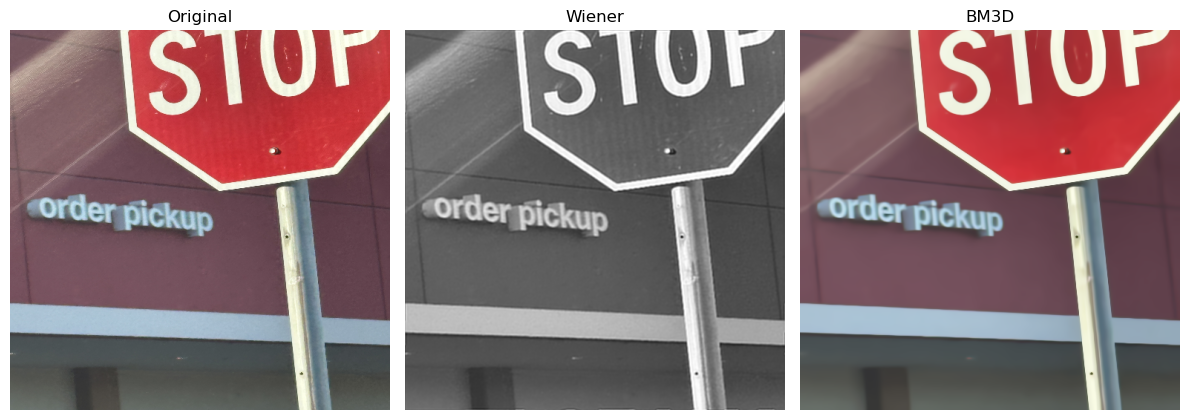

In [59]:
show_custom_dataset(custom_images[5])